<a href="https://colab.research.google.com/github/jdumez10/ML_Apache_Stark_Well_Logs_Prediction/blob/main/ML_Apache_Stark_Well_Logs_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ML with Apache Stark for Sonic Well log data prediction***

The following project has been developed by Juan Diego Dumez García and aims to implement one of the technologies seen in this Big Data module: Apache Spark.

For this project, the dataset of one of the wells in the Volve field of the Norwegian company Equinor will be used. This dataset is freely accessible and can be found on the following page: https://www.equinor.com/en/what-we-do/digitalisation-in-our-dna/volve-field-data-village-download.html.

# ***1. Proposal Definition***

This project aims to build a model that, through supervised learning, allows for the prediction of the transit time of P and S waves in a well based on other data. The implementation of this supervised learning will be done using Apache Spark technology.

## ***1.1. Problem Statement to Solve with Apache Spark***

In the Oil & Gas industry, there are many sources of information that allow for the characterization of rocks containing either oil or gas in place. Among these sources of information are the electrical logs that enable physical measurements of a rock by depth to derive certain properties that are essential for the characterization and exploitation of subsurface resources.



One of the properties that can be measured in the subsurface is the transit time of P and S waves. P waves are compressional waves that are transmitted in a similar way to sound waves, meaning that the particle motion is parallel to the direction of wave propagation (see figure below).

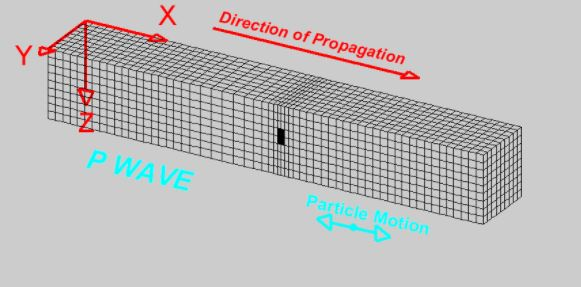

On the other hand, S waves are known as shear waves, which in this case are transmitted differently from P waves. Shear waves cause particle motion perpendicular to the direction of wave propagation (see figure below).

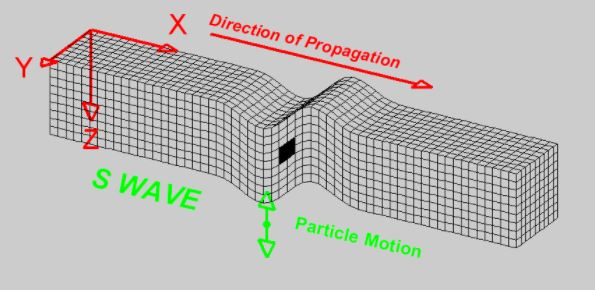

In the industry, an electrical log can be taken to measure the transit time of these waves, and typically, two curves or datasets are obtained. The first one is known as DTC (Compressional Sonic Travel Time), and the second one is known as DTS (Shear Sonic Travel Time). Obtaining these logs can be quite expensive, so it is possible to derive both datasets from another set of curves that are always measured in a well. Taking this into account, the idea is to predict these two curves based on the Caliper, Resistivity, Density, and Neutron logs.

## ***1.2. Installation of Dependencies for Problem Solution***



Taking into account what has been explained before, the import of the corresponding libraries necessary for the problem solution will be carried out. It is emphasized again that for this project, two technologies will be used: Apache Spark and MongoDB. Additionally, other libraries will be imported to complement these analyses.

We install and configure the Java 8 environment variable, and then install the library to connect with PySpark.

In [ ]:
# We install OpenJDK 8 con apt-get.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# We update Java environment variable.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# We install PySpark
!pip install -q pyspark
!pip install -q findspark

In [ ]:
# We import
import pyspark

Now, other libraries that will serve for the project development are imported.

In [ ]:
# Basic Libraries NumPy, Pandas, Matplotlib y Seaborn.
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

In [ ]:
# Libraries versions

!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Plotly', plotly.__version__)
print('PySpark', pyspark.__version__)

Python 3.7.12
NumPy 1.19.5
Pandas 1.1.5
Matplotlib 3.2.2
Seaborn 0.11.2
Plotly 4.4.1
PySpark 3.2.0


This project was carried out with the following versions:
*   Python 3.7.12
*   NumPy 1.19.5
*   Pandas 1.1.5
*   Matplotlib 3.2.2
*   Seaborn 0.11.2
*   Plotly 4.4.1
*   PySpark 3.2.0

# ***2. Data Understanding***

## **2.1. Presentation of the Well Logs Database**

Before presenting the database, the Spark context  (**`pyspark.SparkContext`**) must be declared and stored.

In [ ]:
# Declare the Apache Spark context and store it in the variable 's'
sc = pyspark.SparkContext()

Now, other objects from the **`pysparl.sql`** module are imported.

In [ ]:
# Spark context for SQL operations and DataFrame.
from pyspark.sql import SQLContext

# Row object of a SQL table
from pyspark.sql import Row

# SQLContext object is created
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Now we will proceed to load the database that will be used for this project. This database is stored in a CSV file. To do this, we will import SparkSession and then initialize this session.

In [ ]:
# Import Spark Session
from pyspark.sql import SparkSession

# We initialize this session
spark = SparkSession \
    .builder \
    .getOrCreate()

Now, we will load our database. We have enabled the header option.



In [ ]:
df = spark.read.option("header",True).csv("DataFrame.csv")
print(df)

DataFrame[DEPTH [FT]: string, GR [API]: string, CALI [inches]: string, RT [ohm m]: string, RHOB [g/cm3]: string, NPHI [v/v]: string, PEF [b/elec]: string, DTC [us/ft]: string, DTS [us/ft]: string]


In [ ]:
df.printSchema()

root
 |-- DEPTH [FT]: string (nullable = true)
 |-- GR [API]: string (nullable = true)
 |-- CALI [inches]: string (nullable = true)
 |-- RT [ohm m]: string (nullable = true)
 |-- RHOB [g/cm3]: string (nullable = true)
 |-- NPHI [v/v]: string (nullable = true)
 |-- PEF [b/elec]: string (nullable = true)
 |-- DTC [us/ft]: string (nullable = true)
 |-- DTS [us/ft]: string (nullable = true)



As we can see, the DataFrame has been loaded, but the columns have been read as strings. Let's examine the data to demonstrate that all columns are numeric variables.

In [ ]:
df.show(10)

+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
|DEPTH [FT]|GR [API]|CALI [inches]|RT [ohm m]|RHOB [g/cm3]|NPHI [v/v]|PEF [b/elec]|DTC [us/ft]|DTS [us/ft]|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
| 8615.1577| 64.1063|       8.5469|    1.5664|      2.3107|    0.3031|      5.5161|    97.3205|   184.3431|
| 8615.4858| 64.7338|       8.5469|    1.4696|       2.315|    0.3058|      5.6268|     97.361|   185.3786|
| 8615.8139|  66.159|       8.5469|    1.3698|      2.3214|    0.3069|      5.7457|    97.4018|   186.4142|
|  8616.142| 66.5218|       8.5469|    1.2924|      2.3271|    0.3064|      5.8193|    97.5352|   187.4737|
| 8616.4701| 67.8744|       8.5469|    1.2427|        2.33|    0.3063|      5.8245|    97.7904|   188.5645|
| 8616.7982| 67.9799|       8.5469|    1.2037|      2.3292|    0.3094|      5.7739|    98.0456|   189.6551|
| 8617.1262| 66.6086|       

The modifications to the database will be made in the next section. Generally, the database is structured as follows:

*   **Depth and Gamma Ray Data (Depth Curve):** The Depth curve corresponds to the point where each of the properties measured with electrical logs is taken. The Gamma Ray curve records the natural radiation emitted by rocks, measured in gamma rays.
*   **Caliper Data (Caliper Curve): ** These data represent the true measurement of the hole diameter, which correlates well with the sonic log. As the hole enlarges compared to its original measurement, the formation becomes more unstable, and therefore, the transit time of P and S waves increases.
*   **Resistivity Data (Resistivity Curve):** This log measures the resistivity of a rock. As a rock becomes more compact (with a shorter transit time of P and S waves), it becomes more resistive.
*   **Density Data (RHOB, NPHI, and PEF Curves):**  These correspond to density, hydrogen index, and photoelectric factor measurements, which allow determining the specific lithology of a rock. They also correlate with the transit times of P and S waves.
*   **P-wave Transit Time Data (DTC Curve):** This corresponds to the transit time taken by a P-wave to travel from the emitting tool to the well and back.
*   **S-wave Transit Time Data (DTS Curve):** Similar to the previous measurement but applies to the S-wave.


## **2.2. Modification of the Well Logs Database**

First, the columns of the table are converted to the Double data type.

In [ ]:
# Import IntegerType
from pyspark.sql.types import DoubleType

# Create a list with the column names
columns = df.columns

# Change the data type for each column
for i in range (0,len(df.columns)):
  df = df.withColumn(columns[i], df[i].cast(DoubleType()))

Now, let's note that in this case, we haven't checked whether there are null values in this database or not. In this case, we import some methods to count null values using this library by column.

In [ ]:
# Import the methods to apply
from pyspark.sql.functions import isnan, when, count, col

# Perform the count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
|DEPTH [FT]|GR [API]|CALI [inches]|RT [ohm m]|RHOB [g/cm3]|NPHI [v/v]|PEF [b/elec]|DTC [us/ft]|DTS [us/ft]|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
|         0|       0|            0|         0|           0|         0|           0|          0|          0|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+



In this case, we can see that there are no missing or null values in our dataset. However, this dataset contains values equal to -999, which represent null values. Next, we will transform those values to null and then clean this database.

In [ ]:
# Replace the -999 values with null values
df = df = df.replace(-999,None)

# We make the null values count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
|DEPTH [FT]|GR [API]|CALI [inches]|RT [ohm m]|RHOB [g/cm3]|NPHI [v/v]|PEF [b/elec]|DTC [us/ft]|DTS [us/ft]|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+
|         0|       0|            0|         0|           0|         0|           0|          0|          7|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+



In [ ]:
# Proceed to remove the null data from the table
df = df.na.drop()

# ***3. Preprocessing and Data Splitting of Well Logs***

## ***3.1. Preprocessing of Well Logs Data***

Now we will proceed to preprocess the electrical logs data. In this case, we will perform MinMax scaling normalization on the data to be used for training the model. We will prepare the data as vectors.

The variables to be used for prediction will discard the Depth and Gamma Ray data.

Next, we will import the modules to be used. In this case, we will use VectorAssembler to transform the data into vectors and store them in the same column, MinMaxScaler for normalization, and Pipeline to execute these operations together.

In [ ]:
# Import VectorAssembler to transform the data into vectors
from pyspark.ml.feature import VectorAssembler

# Import MinMaxScaler module for MinMax normalization
from pyspark.ml.feature import MinMaxScaler

# Import Pipeline to carry out data assembling and normalization together
from pyspark.ml import Pipeline

# Select the columns to be used for predicting DTC and DTS data
x_columns = df.columns[2:7]

# Create the model to transform these columns into vectors
assembler_x = VectorAssembler(inputCols = x_columns, 
                              outputCol = "x_columns")


# Create the scaling model to be used
scaler_x = MinMaxScaler(inputCol="x_columns", outputCol="x_scaled")

# Use a Pipeline to carry out data assembling and normalization
pipeline_x = Pipeline(stages=[assembler_x,scaler_x ])

# Create the model
scalerModel_x = pipeline_x.fit(df)

# Apply the transformation
df_scl = scalerModel_x.transform(df)

Now we proceed to verify that the data scaling for x has been done correctly.

In [ ]:
df_scl.show(5)

+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+--------------------+--------------------+
|DEPTH [FT]|GR [API]|CALI [inches]|RT [ohm m]|RHOB [g/cm3]|NPHI [v/v]|PEF [b/elec]|DTC [us/ft]|DTS [us/ft]|           x_columns|            x_scaled|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+--------------------+--------------------+
| 8615.1577| 64.1063|       8.5469|    1.5664|      2.3107|    0.3031|      5.5161|    97.3205|   184.3431|[8.5469,1.5664,2....|[0.19231716326028...|
| 8615.4858| 64.7338|       8.5469|    1.4696|       2.315|    0.3058|      5.6268|     97.361|   185.3786|[8.5469,1.4696,2....|[0.19231716326028...|
| 8615.8139|  66.159|       8.5469|    1.3698|      2.3214|    0.3069|      5.7457|    97.4018|   186.4142|[8.5469,1.3698,2....|[0.19231716326028...|
|  8616.142| 66.5218|       8.5469|    1.2924|      2.3271|    0.3064|      5.8193|    97.5352|   18

There was a limitation regarding the scaling of the data to be predicted (DTC and DTS) because to scale them, they had to be converted into vectors, but then it was not possible to convert the vector data back to numeric values. In order to address this limitation, the MinMax scaling was done manually. In this case, y1 represents the DTC data, and y2 represents the DTS data.

Taking this into account, we will now proceed to obtain the maximum and minimum values of the DTC and DTS data.

In [ ]:
#  DTC
max_y1 = df_scl.agg({'DTC [us/ft]': 'max'}).collect()[0][0]
min_y1 = df_scl.agg({'DTC [us/ft]': 'min'}).collect()[0][0]

# DTS
max_y2 = df_scl.agg({'DTS [us/ft]': 'max'}).collect()[0][0]
min_y2 = df_scl.agg({'DTS [us/ft]': 'min'}).collect()[0][0]

Once we have obtained the maximum and minimum values of each column, we import the set of PySpark functions as F.

In [ ]:
import pyspark.sql.functions as F

Now we proceed to normalize the DTC and DTS data and add them to our dataset.

In [ ]:
# Carry out scaling of the DTC and DTS columns and add them to the dataset

df_scl = df_scl.withColumn('y1_scaled', (F.col('DTC [us/ft]') - min_y1)/(max_y1 - min_y1)) # DTC
df_scl = df_scl.withColumn('y2_scaled', (F.col('DTS [us/ft]') - min_y2)/(max_y2 - min_y2)) # DTS

df_scl.show(10)

+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+--------------------+--------------------+------------------+------------------+
|DEPTH [FT]|GR [API]|CALI [inches]|RT [ohm m]|RHOB [g/cm3]|NPHI [v/v]|PEF [b/elec]|DTC [us/ft]|DTS [us/ft]|           x_columns|            x_scaled|         y1_scaled|         y2_scaled|
+----------+--------+-------------+----------+------------+----------+------------+-----------+-----------+--------------------+--------------------+------------------+------------------+
| 8615.1577| 64.1063|       8.5469|    1.5664|      2.3107|    0.3031|      5.5161|    97.3205|   184.3431|[8.5469,1.5664,2....|[0.19231716326028...|0.6840213670001152|0.7222514066335616|
| 8615.4858| 64.7338|       8.5469|    1.4696|       2.315|    0.3058|      5.6268|     97.361|   185.3786|[8.5469,1.4696,2....|[0.19231716326028...|0.6846980666440544|0.7308043664284559|
| 8615.8139|  66.159|       8.5469|    1.3698|      2.3214| 

## ***3.2. Data Splitting of Well Logs***

Now let's proceed to split the data into training and test subsets with a ratio of 70%-30% and using a seed of 35%.

In [ ]:
# First, create two datasets that will contain only the data to be used for the models
df_p = df_scl.select("y1_scaled","x_scaled")
df_s = df_scl.select("y2_scaled","x_scaled")

# Training data
train_p = df_p.sample(withReplacement=None,fraction = 0.7, seed = 35)
train_s = df_s.sample(withReplacement=None,fraction = 0.7, seed = 35)

# Test data
test_p = df_p.subtract(train_p)
test_s = df_s.subtract(train_s)

# Display the obtained datasets
print(f"Para el DTC:")
train_p.show(5, truncate = False)
test_p.show(5, truncate = False)

print(f"Para el DTS:")
train_s.show(5, truncate = False)
test_s.show(5, truncate = False)

Para el DTC:
+------------------+----------------------------------------------------------------------------------------------------+
|y1_scaled         |x_scaled                                                                                            |
+------------------+----------------------------------------------------------------------------------------------------+
|0.6840213670001152|[0.1923171632602829,3.08041396757174E-5,0.3471448101798298,0.4858206309819213,0.18857673554678434]  |
|0.6846980666440544|[0.1923171632602829,2.8710003345490952E-5,0.3516668419392154,0.4906061680255229,0.20571163222660793]|
|0.6853797788779483|[0.1923171632602829,2.65509660959393E-5,0.3583973078136503,0.4925558312655087,0.22411578051234435]  |
|0.6876087105446513|[0.1923171632602829,2.487652237734914E-5,0.3643916289830688,0.4916696207018788,0.23550808760931824] |
|0.6961367969216014|[0.1923171632602829,2.295761852930073E-5,0.3666000630981177,0.4969868840836583,0.2284807677424349]  |
+----------

# ***4. Supervised Learning - Sonic Log Prediction***

Once the dataset is prepared, we will proceed to train the regression model. The model to be used is the Gradient-boosted tree regression method. First, we import the necessary methods.

In [ ]:
# Import the method to be used
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

Now we proceed to train the model for the DTC and DTS data.

In [ ]:
# We create and train the models
gbtr_y1 = GBTRegressor(featuresCol = "x_scaled", labelCol="y1_scaled", maxIter = 10) # DTC
gbtr_y2 = GBTRegressor(featuresCol = "x_scaled", labelCol="y2_scaled", maxIter = 10) # DTS


gbtr_train_y1 = gbtr_y1.fit(train_p) # DTC
gbtr_train_y2 = gbtr_y2.fit(train_s) # DTS

Once the training is done, we proceed to perform the prediction using the transform method.

In [ ]:
y1_pred = gbtr_train_y1.transform(test_p) # DTC
y2_pred = gbtr_train_y2.transform(test_s) # DTS

# Verify the predicted values
y1_pred.show(5)
y2_pred.show(5)

+--------------------+--------------------+-------------------+
|           y1_scaled|            x_scaled|         prediction|
+--------------------+--------------------+-------------------+
|  0.5919300643449463|[0.19231716326028...| 0.5967393210896662|
|  0.6160957605185023|[0.26914553065747...| 0.5884058170452807|
| 0.12075496288177139|[0.26914553065747...|0.13444706828737107|
|0.018366129595500637|[0.26914553065747...|0.03354069982266569|
| 0.20565988240463962|[0.38463432652056...|0.22165252983265127|
+--------------------+--------------------+-------------------+
only showing top 5 rows

+-------------------+--------------------+-------------------+
|          y2_scaled|            x_scaled|         prediction|
+-------------------+--------------------+-------------------+
| 0.6902829125822257|[0.19231716326028...|  0.712661107481939|
|  0.410249675392255|[0.32725929573996...| 0.4280326607279439|
|0.15283986348303283|[0.26914553065747...|0.18321826776389497|
| 0.1630084282377351|

Finally, we evaluate the performance of these predictions using performance evaluators for the regression model. In this case, we will use R2 and Mean Absolute Error.

In [ ]:
# In this case, we create four performance models
# DTC
evaluator_p_r2 = RegressionEvaluator(predictionCol="prediction", \
              labelCol="y1_scaled",metricName="r2")

evaluator_p_AE = RegressionEvaluator(predictionCol="prediction", \
              labelCol="y1_scaled",metricName="mae")


# DTS
evaluator_s_r2 = RegressionEvaluator(predictionCol="prediction", \
              labelCol="y2_scaled",metricName="r2")

evaluator_s_AE = RegressionEvaluator(predictionCol="prediction", \
              labelCol="y2_scaled",metricName="mae")

In [ ]:
# Obtain the prediction values
print(f"Para el DTC:")
print(f"R2: {evaluator_p_r2.evaluate(y1_pred):.4f}")
print(f"Mean Absolute Error: {evaluator_p_AE.evaluate(y1_pred):.4f}")
print(f" ")

print(f"Para el DTS")
print(f"R2: {evaluator_s_r2.evaluate(y2_pred):.4f}")
print(f"Mean Absolute Error: {evaluator_s_AE.evaluate(y2_pred):.4f}")
print(f" ")

Para el DTC:
R2: 0.9361
Mean Absolute Error: 0.0358
 
Para el DTS
R2: 0.9172
Mean Absolute Error: 0.0392
 


# ***Conclusions***

(1) This project allowed us to apply the methodology of Apache Spark and integrate it with Python through PySpark.

(2) Using this library, we built two models to predict the transit times of the p and s waves in a well in the Volve field. This was done through Supervised Learning.

(3) The method used was Gradient-boosted regressor. We obtained an R2 of 0.93 for the DTC log and an R2 of 0.91 for the DTS log.